In [1]:
import wradlib as wrl
import numpy as np
import sys
import glob
import xarray as xr
import os
import datetime as dt
import pandas as pd
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
#import xradar as xd
#import datatree

In [2]:
import netCDF4
import packaging

In [3]:
assert packaging.version.Version(netCDF4.__version__) <=  packaging.version.Version("1.6.0")

In [4]:
#print(f"xradar: {xd.__version__}")
print(f"wradlib: {wrl.__version__}")
print(f"netCDF4: {netCDF4.__version__}")

wradlib: 1.18.0
netCDF4: 1.6.0


In [5]:
import time
start_time = time.time()

# Read DWD file to retrieve encoding values

In [6]:
dwd = xr.open_dataset("/automount/ags/jgiles/turkey_test/ras07-vol5minng01_sweeph5onem_allmoms_00-2017072700005800-pro-10392-hd5", group="sweep_0")
display(dwd)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 180, time: 288)
Coordinates:
  * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * range              (range) float32 500.0 1.5e+03 ... 1.785e+05 1.795e+05
    elevation          (azimuth) float64 ...
    rtime              (time, azimuth) datetime64[ns] ...
    sweep_mode         object ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
  * time               (time) datetime64[ns] 2017-07-27T00:00:35.538000128 .....
Data variables: (12/24)
    UZDR               (time, azimuth, range) float32 ...
    sweep_number       (time) int64 ...
    prt_mode           (time) object ...
    follow_mode        (time) object ...
    sweep_fixed_angle  (time) float64 ...
    WRADH              (time, azimuth, range) float32 ...
    ...                 ...
    DBZV               (time, azimuth, range) float32 ...
    URHOHV             (time, azimuth, range) float32 ...
    TV                 (time, azimuth, range) float32 ...
    UWRADH             (time, azimuth, range) float32 ...
    VRADH              (time, azimuth, range) float32 ...
    CCORV              (time, azimuth, range) float32 ...
Attributes:
    fixed_angle:  5.4986572265625

# tamper with encoding

In [7]:
drop = ["szip", "zstd", "source", "chunksizes", "bzip2", "blosc", "shuffle", "fletcher32", "original_shape", "coordinates", "contiguous"]
dwd_enc = {k: {key: v.encoding[key] for key in v.encoding if key not in drop} for k, v in dwd.data_vars.items() if v.ndim == 3}
dwd_enc["PHIDP"] = dwd_enc["UPHIDP"]
dwd_enc["DBTH"] = dwd_enc["TH"]
dwd_enc["DBTV"] = dwd_enc["TV"]
dwd_enc


{'UZDR': {'zlib': True,
  'complevel': 6,
  'dtype': dtype('uint16'),
  '_FillValue': 65535,
  'scale_factor': 0.0009766072055300383,
  'add_offset': -32.00097660720553},
 'WRADH': {'zlib': True,
  'complevel': 6,
  'dtype': dtype('uint16'),
  '_FillValue': 65535,
  'scale_factor': 0.0019532144110600766,
  'add_offset': -0.0019532144110600766},
 'ZDR': {'zlib': True,
  'complevel': 6,
  'dtype': dtype('uint16'),
  '_FillValue': 65535,
  'scale_factor': 0.0009766072055300383,
  'add_offset': -32.00097660720553},
 'KDP': {'zlib': True,
  'complevel': 6,
  'dtype': dtype('uint16'),
  '_FillValue': 65535,
  'scale_factor': 0.00045778462759220545,
  'add_offset': -15.000457784627592},
 'DBZH': {'zlib': True,
  'complevel': 6,
  'dtype': dtype('uint16'),
  '_FillValue': 65535,
  'scale_factor': 0.002929821616590115,
  'add_offset': -64.00292982161659},
 'UVRADH': {'zlib': True,
  'complevel': 6,
  'dtype': dtype('uint16'),
  '_FillValue': 65535,
  'scale_factor': 0.003906369212927641,
  'add

# Get File

In [8]:
filename = '/automount/ags/jgiles/turkey_test/acq/OLDDATA/uza/RADAR/2017/07/27/HTY/RAW/HTY170727000050.RAW68UP'

In [9]:
basename = os.path.basename(filename)
basename

'HTY170727000050.RAW68UP'

# set engine

In [10]:
engine = "netcdf4"
#engine = "h5netcdf"

# Reading functions

In [11]:
def read_single_hub(f, scheme="unpacked"):
    reindex = np.arange(0., 360., 1.0)
    ds = xr.open_dataset(f, reindex_angle=reindex, engine="wradlib-iris", group=1, decode_cf=False)
    moments = [k for k,v in ds.variables.items() if v.ndim == 2]
    for mom in moments:
        if mom in ["DB_HCLASS2"]:
            continue
        ds[mom].encoding["_FillValue"] = ds[mom].min().values.item()
        ds[mom] = ds[mom].where(ds[mom] > ds[mom].min().values.item())
    ds = xr.decode_cf(ds)
    return ds

In [12]:
swp0 = read_single_hub(filename).load()
display(swp0)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 832)
Coordinates:
  * azimuth     (azimuth) float32 0.02197 1.038 2.03 3.016 ... 357.1 358.0 359.1
    elevation   (azimuth) float64 -0.02197 -0.02197 ... -0.02197 -0.02197
    rtime       (azimuth) datetime64[ns] 2017-07-27T00:01:13.997000 ... 2017-...
    time        datetime64[ns] 2017-07-27T00:00:50.996999936
  * range       (range) float32 300.0 600.0 900.0 ... 2.493e+05 2.496e+05
    longitude   float64 35.79
    latitude    float64 36.32
    altitude    float64 327.0
    sweep_mode  <U20 'azimuth_surveillance'
Data variables:
    DBTH        (azimuth, range) float64 4.14 4.99 -7.85 0.83 ... nan nan nan
    DBZH        (azimuth, range) float64 nan nan nan -13.95 ... nan nan nan nan
    VRADH       (azimuth, range) float64 nan nan nan -7.07 ... nan nan nan nan
    WRADH       (azimuth, range) float64 nan 0.83 0.67 0.01 ... nan nan nan nan
    ZDR         (azimuth, range) float64 0.56 -0.72 1.97 2.53 ... nan nan nan
    KDP         (azimuth, range) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    RHOHV       (azimuth, range) float64 0.3952 0.7076 0.8306 ... nan nan nan
    SQIH        (azimuth, range) float64 0.265 0.9474 0.9469 ... 0.07506 nan nan
    PHIDP       (azimuth, range) float64 231.8 217.9 181.9 206.7 ... nan nan nan
    DB_HCLASS2  (azimuth, range) int16 17 9 9 105 17 9 17 9 ... 0 0 0 0 0 0 0 0
Attributes:
    fixed_angle:  0.0

In [13]:
def process_single_hub(f, scheme="unpacked", sdict={}):
    ds = read_single_hub(f, scheme=scheme)
    moments = [k for k,v in ds.variables.items() if v.ndim == 2]
    if "unpacked" in scheme:
        valid = ["dtype", "_FillValue"]
        new_enc = {k: {key: val for key, val in ds[k].encoding.items() if key in valid} for k in moments}
    else:
        new_enc = {k: dwd_enc[k] for k in moments if k in dwd_enc}
        
    shape = ds[moments[0]].shape
    enc_new = dict(chunksizes=shape)
    enc_new.update(sdict)
    [new_enc[k].update(enc_new) for k in new_enc]
    dest = f"{os.path.basename(f)}-{scheme}.nc"
    if os.path.exists(dest):
        os.unlink(dest)
    #print(new_enc)
    ds.to_netcdf(dest, engine=engine, encoding=new_enc)
    return dest

In [14]:
fnames = []

In [15]:
%%time
fname = process_single_hub(filename, 
                           scheme="unpacked1", 
                          )
fnames.append(fname)

CPU times: user 2.76 s, sys: 5.84 ms, total: 2.77 s
Wall time: 2.95 s


In [16]:
%%time
fname = process_single_hub(filename, 
                           scheme="unpacked2", 
                           sdict=dict(zlib=True, 
                                      complevel=6, 
                                     )
                          )
fnames.append(fname)

CPU times: user 3.29 s, sys: 31.1 ms, total: 3.33 s
Wall time: 3.37 s


In [17]:
%%time
fname = process_single_hub(filename, 
                            scheme="unpacked3", 
                            sdict=dict(zlib=True, 
                                       complevel=6, 
                                       least_significant_digit=3,
                                      )
                           )
fnames.append(fname)

CPU times: user 3.19 s, sys: 31.2 ms, total: 3.22 s
Wall time: 3.36 s


In [18]:
%%time
fname = process_single_hub(filename, 
                            scheme="unpacked4", 
                            sdict=dict(zlib=True, 
                                       complevel=6, 
                                       least_significant_digit=4,
                                      )
                           )
fnames.append(fname)

CPU times: user 3.17 s, sys: 40.2 ms, total: 3.22 s
Wall time: 3.34 s


In [19]:
%%time
fname = process_single_hub(filename, scheme="packed")
fnames.append(fname)

CPU times: user 2.89 s, sys: 9.76 ms, total: 2.9 s
Wall time: 2.9 s


In [20]:
fstats = [os.stat(f) for f in fnames]
[print(f"{f : <36}:{fs.st_size : >10}") for f, fs in zip(fnames, fstats)]


HTY170727000050.RAW68UP-unpacked1.nc:  22223310
HTY170727000050.RAW68UP-unpacked2.nc:   3857106
HTY170727000050.RAW68UP-unpacked3.nc:   1852833
HTY170727000050.RAW68UP-unpacked4.nc:   2268641
HTY170727000050.RAW68UP-packed.nc   :   2037883


[None, None, None, None, None]

In [21]:
%%time
swp1 = xr.open_dataset(fnames[0]).load()

CPU times: user 16.8 ms, sys: 12.2 ms, total: 28.9 ms
Wall time: 28.2 ms


In [22]:
%%time
swp2 = xr.open_dataset(fnames[1]).load()

CPU times: user 90.4 ms, sys: 12.3 ms, total: 103 ms
Wall time: 102 ms


In [23]:
%%time
swp3 = xr.open_dataset(fnames[2]).load()

CPU times: user 100 ms, sys: 309 µs, total: 100 ms
Wall time: 98.9 ms


In [24]:
%%time
swp4 = xr.open_dataset(fnames[3]).load()

CPU times: user 93 ms, sys: 7.81 ms, total: 101 ms
Wall time: 99.1 ms


In [25]:
%%time
swp5 = xr.open_dataset(fnames[4]).load()

CPU times: user 43.8 ms, sys: 3.94 ms, total: 47.7 ms
Wall time: 46.3 ms


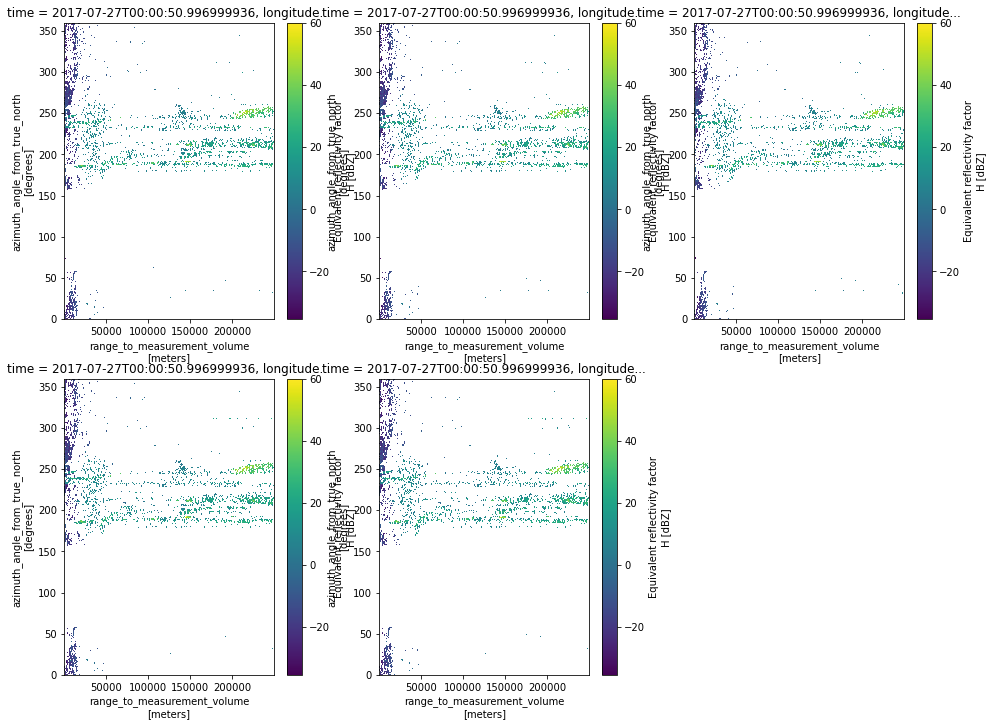

In [26]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(231)
swp1.DBZH.plot(center=False, ax=ax1)
ax2 = fig.add_subplot(232)
swp2.DBZH.plot(center=False, ax=ax2)
ax3 = fig.add_subplot(233)
swp3.DBZH.plot(center=False, ax=ax3)
ax4 = fig.add_subplot(234)
swp4.DBZH.plot(center=False, ax=ax4)
ax5 = fig.add_subplot(235)
swp5.DBZH.plot(center=False, ax=ax5)

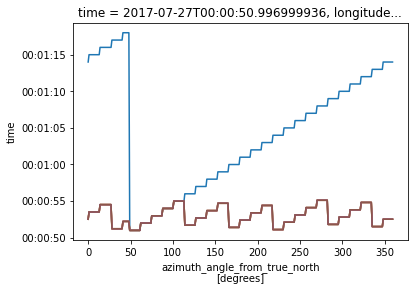

In [27]:
swp0.rtime.plot()
swp1.rtime.plot()
swp2.rtime.plot()
swp3.rtime.plot()
swp4.rtime.plot()
swp5.rtime.plot()

In [28]:
moments = [k for k,v in swp0.variables.items() if v.ndim == 2]
moments

['DBTH',
 'DBZH',
 'VRADH',
 'WRADH',
 'ZDR',
 'KDP',
 'RHOHV',
 'SQIH',
 'PHIDP',
 'DB_HCLASS2']

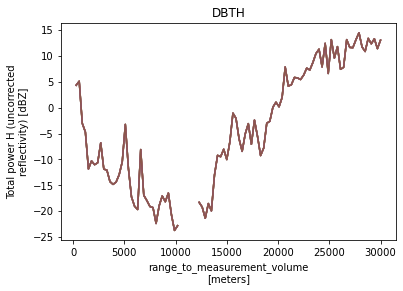

In [29]:
mom = moments[0]
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)

np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-02)

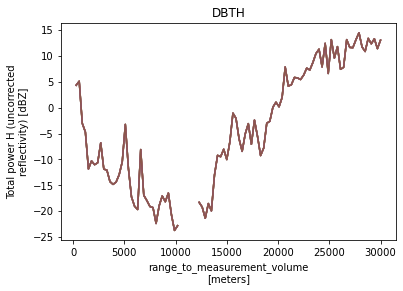

In [30]:
mom = "DBTH"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)

np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-02)

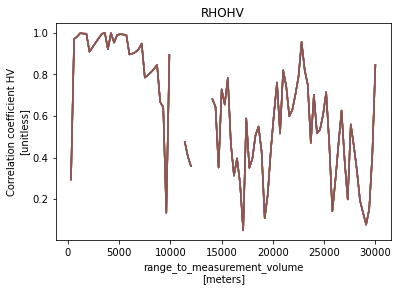

In [31]:
mom = "RHOHV"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)

np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-05)

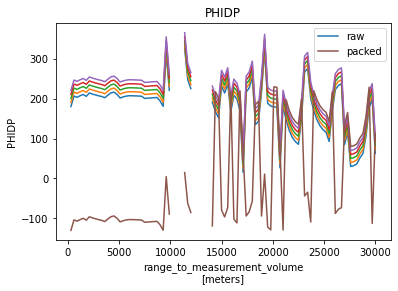

In [32]:
mom = "PHIDP"
swp0[mom][250, 0:100].plot(label="raw")
(swp1[mom][250, 0:100]+10).plot()
(swp2[mom][250, 0:100]+20).plot()
(swp3[mom][250, 0:100]+30).plot()
(swp4[mom][250, 0:100]+40).plot()
(swp5[mom][250, 0:100]+50).plot(label="packed")
plt.legend()
plt.title(mom)

np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
#np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-02)

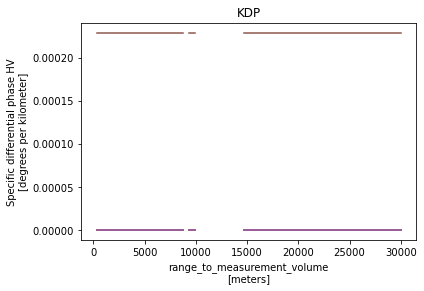

In [33]:
mom = "KDP"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)


np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-05)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-03)

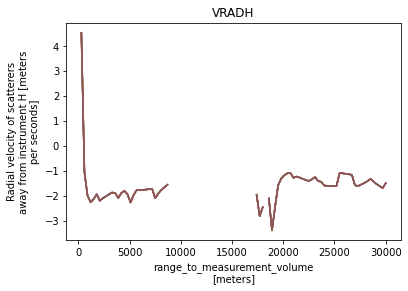

In [34]:
mom = "VRADH"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)


np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-02)

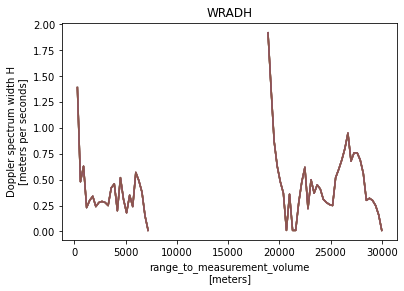

In [35]:
mom = "WRADH"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)


np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-03)


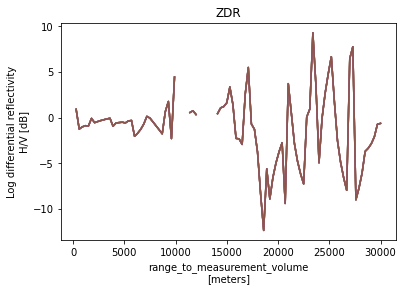

In [36]:
mom = "ZDR"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)


np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
#np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-02)

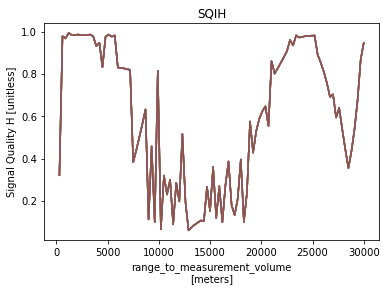

In [37]:
mom = "SQIH"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)


np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values, rtol=False, atol=1e-03)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values, rtol=False, atol=1e-04)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values, rtol=False, atol=1e-02)

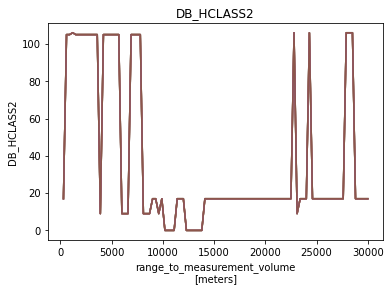

In [38]:
mom = "DB_HCLASS2"
swp0[mom][250, 0:100].plot()
swp1[mom][250, 0:100].plot()
swp2[mom][250, 0:100].plot()
swp3[mom][250, 0:100].plot()
swp4[mom][250, 0:100].plot()
swp5[mom][250, 0:100].plot()
plt.title(mom)


np.testing.assert_allclose(swp0[mom].values, swp1[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp2[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp3[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp4[mom].values)
np.testing.assert_allclose(swp0[mom].values, swp5[mom].values)